In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna 
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from matplotlib import pyplot
import matplotlib.pyplot as plt

from prediction import LtrPrediction
from processing_transE import DataPreprocessing
import ltr_utils as ut

There was a problem when trying to write in your cache folder (/home/devpil/.cache/huggingface/hub). You should set the environment variable TRANSFORMERS_CACHE to a writable directory.


## Datasets

In [2]:
train = pd.read_csv("../Dataset/train.csv")
test = pd.read_csv("../Dataset/test.csv")
articles = pd.read_csv("../Dataset/articles.csv")
users = pd.read_csv("../Dataset/users.csv")

## Data Preprocessing

In [3]:
data_dict = {
    'train' : '../Dataset/train.csv',
    'test' : '../Dataset/test.csv',
    'articles' : '../Dataset/articles.csv',
    'users' : '../Dataset/users.csv'
}

In [4]:
DataPrep = DataPreprocessing(data_dict)

(11020, 19) (25672, 19)


In [5]:
DataPrep.init_KG('TransE/transE_combined_emb.txt')

In [6]:
DataPrep.init_SentenceTransformer('all-MiniLM-L6-v2')

In [7]:
train_data_df, test_data_df = DataPrep.fit_data_pipeline()

100%|██████████| 25672/25672 [25:22<00:00, 16.87it/s]
/home/devpil/anaconda3/envs/fid_xgboost/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 11020/11020 [10:46<00:00, 17.04it/s]


In [8]:
processed_data_dict = DataPrep.get_train_test_split(['art','usr','kg'])

87
(25672, 87) (25672, 1) (11020, 87) (11020, 1)


In [9]:
X_train, y_train, groups_train, qid_train, X_test, y_test, qid_test, groups_test = processed_data_dict['train_test']
test_data = processed_data_dict['test_data']

## Model Training

In [4]:
xgb_params = {  'booster':"gbtree", 
                'objective':"rank:pairwise",
                'tree_method':"gpu_hist", 
                'sampling_method':"gradient_based",
                'eval_metric':['map@10'],
             }

model = xgb.XGBRanker(**xgb_params)


model.fit(X_train, y_train, group=groups_train, eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[groups_train,groups_test],  verbose=False)

result = model.evals_result()
train_score = np.mean(result['validation_0']['map@10'])
test_score = np.mean(result['validation_1']['map@10'])
print('default Train :  ', train_score)
print('default Test  :  ', test_score)

default Train :   0.3939034580161696
default Test  :   0.14900344768336898


## Hyperparameter Tuning

In [6]:
def objective(trial):

        metric = "map@10"

        tuning_params = {
                    "max_depth": trial.suggest_int("max_depth", 2, 8, step=1),
                    "subsample": trial.suggest_float("subsample", 0.5, 0.8, step=0.05),
                    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.8, step=0.05),
                    "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 10.0, step=0.01),
                    "alpha": trial.suggest_float("alpha", 1e-8, 1.0),
                    "min_child_weight": trial.suggest_float("min_child_weight", 0.01, 10.0, step=0.01),
                    "gamma": trial.suggest_float("gamma", 0.01, 10.0, step=0.01),
                    "max_delta_step":  trial.suggest_float("max_delta_step", 0.01, 10.0, step=0.01),
                    "eta": trial.suggest_float("eta", 0.001, 10.0, step=0.001)

                }
        
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-map@10")

        model = xgb.XGBRanker(booster="gbtree", objective="rank:pairwise",
                            tree_method="gpu_hist", sampling_method="gradient_based",
                            eval_metric=metric,
                            verbosity=1,
                            n_estimators=5000,
                            **tuning_params)

        model.fit(X_train, y_train, group=groups_train, eval_set=[(X_test, y_test)],early_stopping_rounds = 100,  eval_group=[groups_test], callbacks=[pruning_callback],  verbose=False)

        result = model.evals_result()
        opt_score1 = np.mean(result['validation_0'][metric])

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        return opt_score1

# optuna.logging.WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

pruner = optuna.pruners.MedianPruner(n_warmup_steps=20)
study = optuna.create_study(pruner=pruner, direction='maximize')
study.optimize(objective, n_trials=500)

/home/devpil/anaconda3/envs/fid_xgboost/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,
/home/devpil/anaconda3/envs/fid_xgboost/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  UserWarning,


In [7]:
print(f"Optimized MAP: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized MAP: 0.2737
Best params:
	max_depth: 5
	subsample: 0.8
	colsample_bytree: 0.65
	reg_lambda: 5.06
	alpha: 0.38286835596574587
	min_child_weight: 3.29
	gamma: 5.85
	max_delta_step: 0.01
	eta: 5.5120000000000005


In [8]:
metric = "map@10"

model_bst = xgb.XGBRanker(booster="gbtree", objective="rank:pairwise",
                        tree_method="gpu_hist", sampling_method="gradient_based",
                        eval_metric=metric,
                        n_estimators=5000,
                        early_stopping_rounds = 50, 
                        verbosity=0,
                        **study.best_params)

model_bst.fit(X_train, y_train, group=groups_train, eval_set=[(X_train, y_train),(X_test, y_test)], eval_group=[groups_train,groups_test],  verbose=False)
result = model_bst.evals_result()
train_score = np.max(result['validation_0']['map@10'])
test_score = np.max(result['validation_1']['map@10'])
print('Optimized Train :  ', train_score)
print('Optimized Test  :  ', test_score)

Optimized Train :   0.25888226927431646
Optimized Test  :   0.29556126326220433


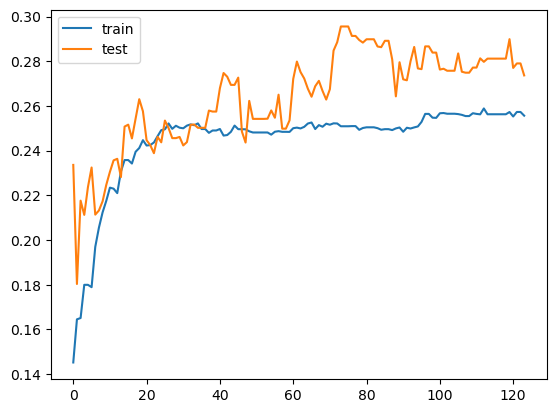

In [9]:
# plot learning curves
pyplot.plot(result['validation_0']['map@10'], label='train')
pyplot.plot(result['validation_1']['map@10'], label='test')
# show the legend
pyplot.legend()
pyplot.rcParams["figure.figsize"] = (10,5)
# show the plot
pyplot.show()

In [41]:
path = 'outputs/kg_DP/'
ut.model_save(model_bst,path,DataPrep)

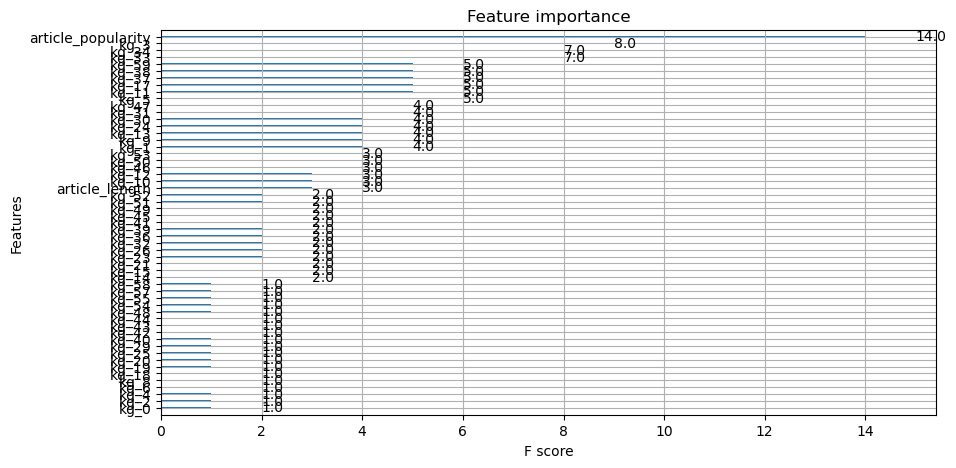

In [10]:
xgb.plot_importance(model_bst)
plt.show()

## Model Evaluation

In [3]:
path = 'outputs/kg_DP/'

model_bst, DataPrep = ut.load_model(path)

processed_data_dict = DataPrep.get_train_test_split(['art','usr','kg'])
X_train, y_train, groups_train, qid_train, X_test, y_test, qid_test, groups_test = processed_data_dict['train_test']
test_data = processed_data_dict['test_data']

87
(25672, 87) (25672, 1) (11020, 87) (11020, 1)


In [11]:
xgb_Prediction = LtrPrediction(model_bst, test_data)

In [12]:
results = xgb_Prediction.evaluate()
results

NDCG=0.496 | Recall=0.706 | Precision=0.946 


{'MAP@10': 0.3363490303528819,
 'results@10': {'NDCG': 0.49642469062027683,
  'Recall': 0.7055114638447971,
  'Precision': 0.23202614379084968}}

In [18]:
top_k_best_score_ips = xgb_Prediction.get_recomendation()

In [19]:
tcm_le = DataPrep.return_inverse_transform()
top_k_best_score_ips['article_actual_ids'] = top_k_best_score_ips.apply(lambda row: tcm_le.inverse_transform(row['article_actual']) ,axis=1)
top_k_best_score_ips['article_recomended_ids'] = top_k_best_score_ips.apply(lambda row: tcm_le.inverse_transform(row['article_prediction']) ,axis=1)

In [20]:
pd.set_option('max_columns', None)
pd.set_option('display.max_colwidth', None)
top_k_best_score_ips[['article_actual_ids','article_recomended_ids','apk']].sort_values(by='apk',ascending = False).head(10)

,article_actual_ids,article_recomended_ids,apk
qid,,,
32975618,[tcm:526-388698],"[tcm:526-388698, tcm:526-249037, tcm:526-259315, tcm:526-13782, tcm:526-70899, tcm:526-681575, tcm:526-276414, tcm:526-149043, tcm:526-10787, tcm:526-208086]",1.0
24129890,[tcm:526-93195],"[tcm:526-93195, tcm:526-209028, tcm:526-492865, tcm:526-13782, tcm:526-276414, tcm:526-16645, tcm:526-12180, tcm:526-149043, tcm:526-208086, tcm:526-670542]",1.0
67695988,[tcm:526-70899],"[tcm:526-70899, tcm:526-249037, tcm:526-237984, tcm:526-13782, tcm:526-22867, tcm:526-16645, tcm:526-244935, tcm:526-681575, tcm:526-12180, tcm:526-116442]",1.0
2570506,[tcm:526-261006],"[tcm:526-261006, tcm:526-237984, tcm:526-385364, tcm:526-16645, tcm:526-681575, tcm:526-22867, tcm:526-782343, tcm:526-653510, tcm:526-149043, tcm:526-276414]",1.0
64920697,"[tcm:526-492865, tcm:526-249037, tcm:526-93195]","[tcm:526-492865, tcm:526-93195, tcm:526-249037, tcm:526-224772, tcm:526-244935, tcm:526-681575, tcm:526-16645, tcm:526-12180, tcm:526-682576, tcm:526-12167]",1.0
36756635,[tcm:526-249037],"[tcm:526-249037, tcm:526-13782, tcm:526-385364, tcm:526-80807, tcm:526-259315, tcm:526-681575, tcm:526-653510, tcm:526-149043, tcm:526-248966, tcm:526-208086]",1.0
45841437,[tcm:526-273898],"[tcm:526-273898, tcm:526-385364, tcm:526-13782, tcm:526-16645, tcm:526-782343, tcm:526-653510, tcm:526-22867, tcm:526-149043, tcm:526-682576, tcm:526-208086]",1.0
34391842,[tcm:526-93195],"[tcm:526-93195, tcm:526-237984, tcm:526-13782, tcm:526-385364, tcm:526-259315, tcm:526-70899, tcm:526-22867, tcm:526-244935, tcm:526-16645, tcm:526-12167]",1.0
65703510,"[tcm:526-70899, tcm:526-261006]","[tcm:526-261006, tcm:526-70899, tcm:526-273898, tcm:526-385364, tcm:526-244935, tcm:526-681575, tcm:526-149043, tcm:526-208086, tcm:526-346380, tcm:526-116442]",1.0


## SHAP

In [17]:
import shap

In [18]:
explainer = shap.Explainer(model_bst)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


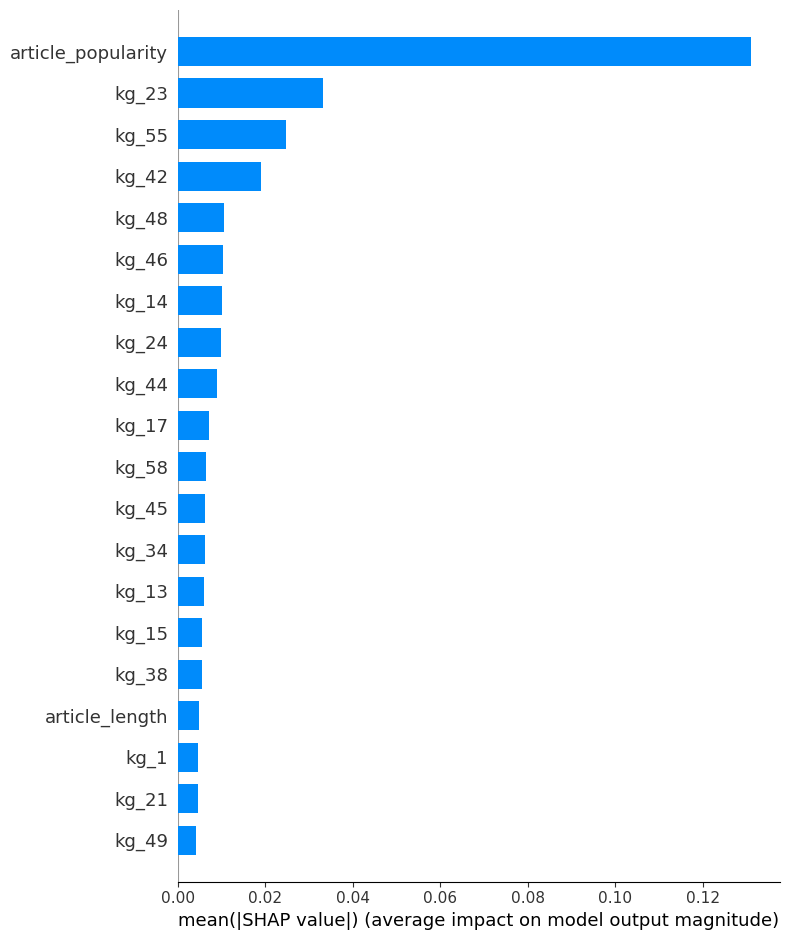

In [19]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

## ELI5

In [20]:
from eli5.xgboost import explain_weights_xgboost

In [21]:
explain_weights_xgboost(model_bst)

Weight,Feature
0.0713,article_popularity
0.0532,kg_23
0.0419,article_length
0.0398,kg_55
0.0387,kg_48
0.0344,kg_42
0.0280,kg_24
0.0255,kg_44
0.0252,kg_14
0.0223,kg_46
